# End-to-End Machine Learning Project

In this chapter, you will go through and example project end to end, pretending to be recently hired data scientist in a real estate company. Here are the main steps you will go through.

1. Look at the big picture
2. Get the data.
3. Discover and visualize the data to gain insights/
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, moniter, and maintain your system.

# ~ Look at the Big Picture

Welcome to Machine Learning Housing Corporation! The first task you are asked to perform is to build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short. Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

# ~ Frame the Problem

The first question to ask your boss is what exactly is the business objective; building a model is probably not the end goal. How does the company expect to use and benefit from this model? This is important because it will determine how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it. Your boss answers that your model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals.3 This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.

The next question to ask is what the current solution looks like (if any). It will often give you a reference performance, as well as insights on how to solve the problem. Your boss answers that the district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district (excluding median housing prices), and they use complex rules to come up with an estimate. This is costly and time-consuming, and their estimates are not great; their typical error rate is about 15%.

Okay, with all this information you are now ready to start designing your system. First, you need to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? Before you read on, pause and try to answer these questions for yourself.

Have you found the answers? Let’s see: it is clearly a typical supervised learning task since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). Moreover, it is also a typical regression task, since you are asked to predict a value. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). In the first chapter, you predicted life satisfaction based on just one feature, the GDP per capita, so it was a univariate
regression problem. Finally, there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.


# ~ Select a Performance Measure
Your next step is to select a performance measure. A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It measures the standard deviation4 of the errors the system makes in its predictions. For example, an RMSE equal to 50,000 means that about 68% of the system’s predictions fall within $50,000 of the actual value, and about 95% of the predictions fall within $100,000 of the actual value.

<img src="img23.PNG">

Even though the RMSE is generally the preferred performance measure for regression tasks, in some contexts you may prefer to use another function. For example, suppose that there are many outlier districts. In that case, you may consider using the Mean Absolute Error (also called the Average Absolute Deviation;

<img src="img24.PNG">

Both the RMSE and the MAE are ways to measure the distance between two vectors: the vector of predictions and the vector of target values. Various distance measures, or norms, are possible: 

    * Computing the root of a sum of squares (RMSE) corresponds to the Euclidian norm: it is the notion of distance you are familiar with. It is also called the ℓ2 norm, noted ∥ · ∥2 (or just ∥ · ∥).
    
    * Computing the sum of absolutes (MAE) corresponds to the ℓ1 norm, noted ∥ · ∥1. It is sometimes called the Manhattan norm because it measures the distance between two points in a city if you can only travel along orthogonal city blocks.
    
    * More generally, the ℓk norm of a vector v containing n elements is defined as . ℓ0 just gives the cardinality of the vector (i.e., the number of elements), and ℓ∞ gives the maximum absolute value in the vector. 
    
    * The higher the norm index, the more it focuses on large values and neglects small ones. This is why the RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.
    
# Check the Assumptions

Lastly, it is good practice to list and verify the assumptions that were made so far (by you or others); this can catch serious issues early on. For example, the district prices that your system outputs are going to be fed into a downstream Machine Learning system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months. 

Fortunately, after talking with the team in charge of the downstream system, you are confident that they do indeed need the actual prices, not just categories. Great! You’re all set, the lights are green, and you can start coding now!

# ~ Get the Data

In [5]:
# Download the data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing" 
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):  
    if not os.path.isdir(housing_path):    
        os.makedirs(housing_path)   
    tgz_path = os.path.join(housing_path, "housing.tgz")  
    urllib.request.urlretrieve(housing_url, tgz_path)   
    housing_tgz = tarfile.open(tgz_path)  
    housing_tgz.extractall(path=housing_path) 
    housing_tgz.close() 
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):  
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

In [7]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values 

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards, but it’s perfect to get started. Notice that the total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later. 

All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object but since you loaded this data from a CSV file you know that it must be a text attribute. When you looked at the top five rows, you probably noticed that the values in that column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the value_counts() method: 

In [9]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
# Let's look at the other field. The describe method shows a summary of the numerical attirb:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for example, count of total_bedrooms is 20,433, not 20,640). The std row shows the standard deviation (which measures how dispersed the values are). The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations falls. For example, 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile). 

Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the hist() method on the whole dataset, and it will plot a histogram for each numerical attribute. For example, you can see that slightly over 800 districts have a median_house_value equal to about $500,000.


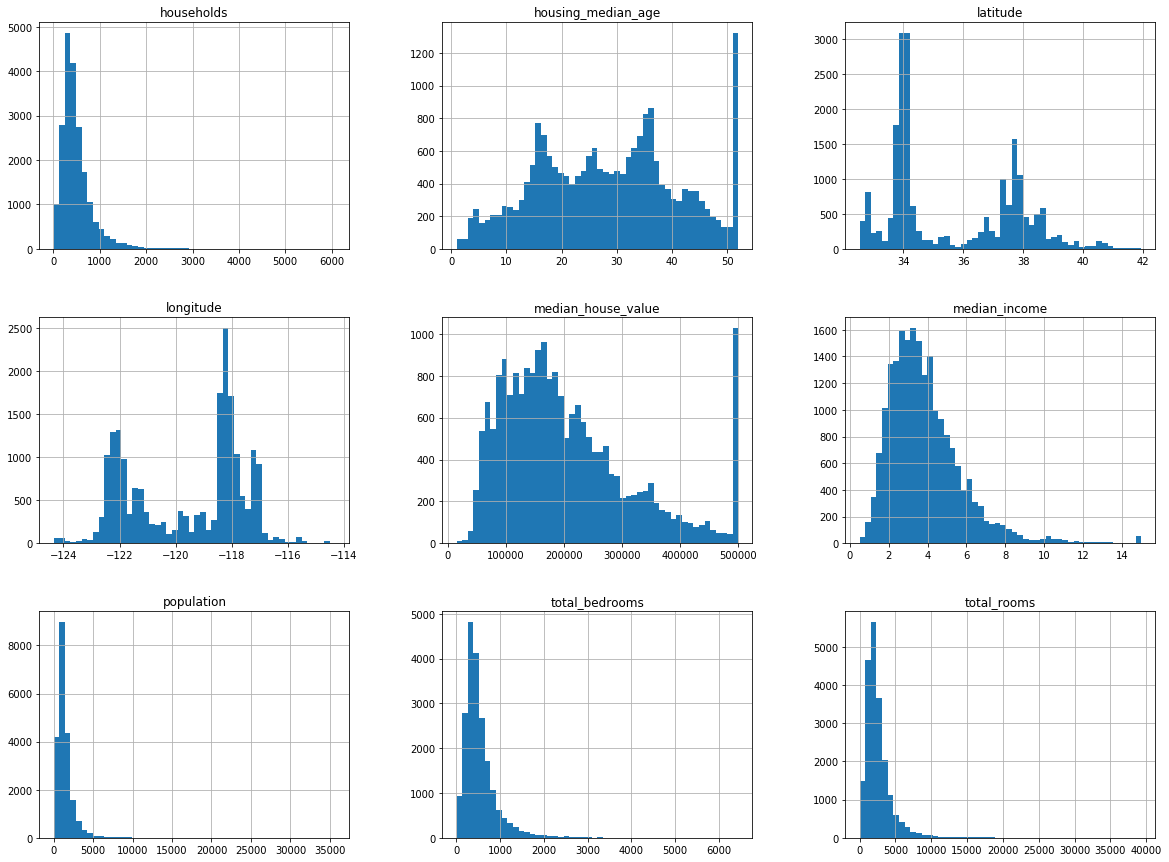

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

The hist() method relies on Matplotlib, which in turn relies on a user-specified graphical backend to draw on your screen. So before you can plot anything, you need to specify which backend Matplotlib should use. The simplest option is to use Jupyter’s magic command %matplotlib inline. This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend. Plots are then rendered within the notebook itself. Note that calling show() is optional in a Jupyter notebook, as Jupyter will automatically display plots when a cell is executed.

Notice a few things in these histograms:

    1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.
    
    2.  The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have mainly two options:
        a. Collect proper labels for the districts whose labels were capped
        b.  Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000). 


# Create a Test set

It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. When you estimate the generalization error using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called data snooping bias.

In [12]:
import numpy as np
np.random.seed(42)

def split_train_test(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]    
    return data.iloc[train_indices],data.iloc[test_indices]

train_set,test_set=split_train_test(housing,0.2)
print(len(train_set)," train + ",len(test_set)," test")

16512  train +  4128  test


Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., np.random.seed(42)) before calling np.random.permutation(), so that it always generates the same shuffled indices. 

But both these solutions will break next time you fetch an updated dataset. A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set. Here is a possible implementation:


In [13]:
import hashlib

def test_set_check(identifier,test_ratio,hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio

def split_train_test_by_id(data,test_ratio,id_column,hash=hashlib.md5):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:test_set_check(id_,test_ratio,hash))
    return data.loc[~in_test_set],data.loc[in_test_set]

housing_with_id=housing.reset_index()

train_set,test_set=split_train_test_by_id(housing_with_id,0.2,'index')

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so

In [14]:
housing_with_id['id']=housing['longitude']*100+housing['latitude']
train_set,test_set=split_train_test_by_id(housing_with_id,0.2,'id')

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First there is a random_state parameter that allows you to set the random generator seed as explained previously, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):


In [15]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone booth. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased. 

Most median income values are clustered around 2–5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:


In [51]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) 
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit 

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):  
    strat_train_set = housing.loc[train_index]   
    strat_test_set = housing.loc[test_index]

c:\users\deepblue\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
c:\users\deepblue\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [53]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [54]:
# Now you should remove the income_cat attribute so the data is back to its original state
for set in (strat_train_set, strat_test_set):   
    set.drop(["income_cat"], axis=1, inplace=True)

We spent quite a bit of time on test set generation for a good reason: this is an often neglected but critical part of a Machine Learning project. Moreover, many of these ideas will be useful later when we discuss cross-validation. Now it’s time to move on to the next stage: exploring the data.

# ~ Discover and Visualize the Data to Gain Insights
So far you have only taken a quick glance at the data to get a general understanding of the kind of data you are manipulating. Now the goal is to go a little bit more in depth. 

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:


In [55]:
housing=strat_train_set.copy()

# ~ Visualizing Geographical Data
Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data 

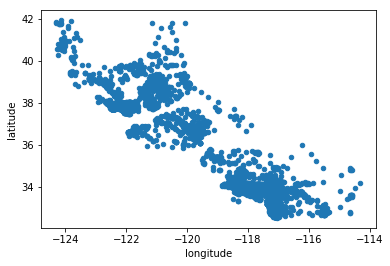

In [56]:
housing.plot(kind='scatter',x='longitude',y='latitude')

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points 

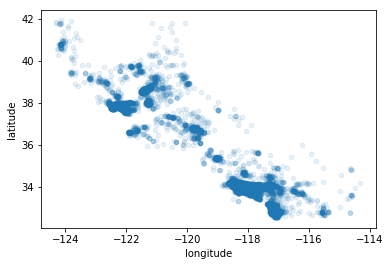

In [61]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno. 

More generally, our brains are very good at spotting patterns on pictures, but you may need to play around with visualization parameters to make the patterns stand out. 

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

ValueError: 'c' argument must either be valid as mpl color(s) or as numbers to be mapped to colors. Here c = median_house_value.

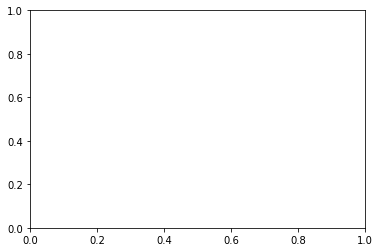

In [62]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
             s=housing['population']/100,label='population',c='median_house_value',
            cmap=plt.get_cmap('jet'),colorbar=True)
plt.legend()

# ~ Looking for Correlation
Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method:


In [63]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

KeyError: 'median_house_value'

In [25]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924290,-0.105099,0.043278,0.069716,0.097509,0.055359,-0.017230,-0.041032
latitude,-0.924290,1.000000,0.009917,-0.036190,-0.068481,-0.107823,-0.072261,-0.079920,-0.149359
housing_median_age,-0.105099,0.009917,1.000000,-0.359427,-0.319869,-0.294226,-0.303019,-0.117111,0.101691
total_rooms,0.043278,-0.036190,-0.359427,1.000000,0.931504,0.855610,0.920017,0.199214,0.136181
total_bedrooms,0.069716,-0.068481,-0.319869,0.931504,1.000000,0.876916,0.980263,-0.004526,0.053249
population,0.097509,-0.107823,-0.294226,0.855610,0.876916,1.000000,0.905975,0.005398,-0.023968
households,0.055359,-0.072261,-0.303019,0.920017,0.980263,0.905975,1.000000,0.015685,0.068845
median_income,-0.017230,-0.079920,-0.117111,0.199214,-0.004526,0.005398,0.015685,1.000000,0.692464
median_house_value,-0.041032,-0.149359,0.101691,0.136181,0.053249,-0.023968,0.068845,0.692464,1.000000


Another way to check for correlation between attributes is to use Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page, so let’s just focus on a few promising attributes that seem most correlated with the median housing value 

c:\users\deepblue\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


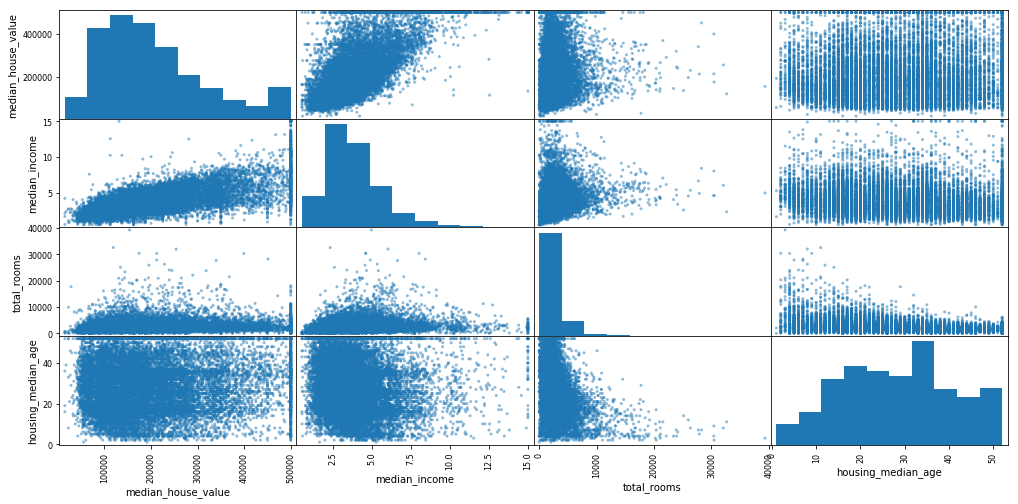

In [26]:
from pandas.tools.plotting import scatter_matrix
attributes=['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(17,8))
plt.show()

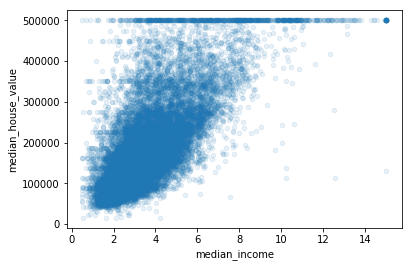

In [27]:
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

# Experimenting with Attribute Combinations

Hopefully the previous sections gave you an idea of a few ways you can explore the data and gain insights. You identified a few data quirks that you may want to clean up before feeding the data to a Machine Learning algorithm, and you found interesting correlations between attributes, in particular with the target attribute. You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm). Of course, your mileage will vary considerably with each project, but the general ideas are similar. 

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [28]:
housing['rooms_per_househole']=housing['total_rooms']/housing['households']
housing['bedrooms_per_room']=housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household']=housing['population']/housing['households']

In [29]:
# Check correlation matrix again:
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.692464
rooms_per_househole         0.155001
total_rooms                 0.136181
housing_median_age          0.101691
households                  0.068845
total_bedrooms              0.053249
population                 -0.023968
population_per_household   -0.025800
longitude                  -0.041032
latitude                   -0.149359
bedrooms_per_room          -0.259161
Name: median_house_value, dtype: float64

Hey, not bad! The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district — obviously the larger the houses, the more expensive they are. 

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

# ~ Prepare the Data for Machine Learning Algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of just doing this manually, you should write functions to do that, for several good reasons: 
    * This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset). 
    * You will gradually build a library of transformation functions that you can reuse in future projects. 
    * You can use these functions in your live system to transform the new data before feeding it to your algorithms.
    * This will make it possible for you to easily try various transformations and see which combination of transformations works best.
    
But first let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set):


In [30]:
housing=strat_train_set.drop('median_house_value',axis=1)
housing_labels=strat_train_set['median_house_value'].copy()

# Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

    * Get rid of the Corresponding districts.
    * Get rid og the whole attribute.
    * Set the values to some value(zero,the mean,the median,etc)
    

In [31]:
housing.dropna(subset=['total_bedrooms']) #option 1
housing.drop('total_bedrooms',axis=1) #option 2
median=housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median) # option 3

13643     149.0
11573     267.0
20322      75.0
16484     102.0
12136     239.0
6388      218.0
11197     612.0
20206     295.0
1657      884.0
10829     314.0
1688      479.0
14860     533.0
5721      345.0
13304     816.0
8984       72.0
18972     343.0
16492     188.0
13297     258.0
7978      396.0
189       395.0
1255      250.0
9939       18.0
477       435.0
9791      274.0
11439     291.0
17356     376.0
1870      536.0
10557     745.0
4994      636.0
3082      403.0
          ...  
9955       68.0
10202      87.0
5770      356.0
8315      591.0
849       302.0
13272     516.0
11101     346.0
4440      808.0
3113     1138.0
5540     3984.0
2590      495.0
19750     584.0
17620     552.0
735       398.0
15952     319.0
15061    3093.0
7378      349.0
16248     184.0
12680     431.0
873       312.0
14399     377.0
16488     435.0
7297      215.0
11973     621.0
5341        7.0
10364     405.0
18097     824.0
6537      731.0
2227      544.0
10725     260.0
Name: total_bedrooms, Le

If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data. 

Scikit-Learn provides a handy class to take care of missing values: Imputer. Here is how to use it. First, you need to create an Imputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute: 

In [32]:
from sklearn.preprocessing import Imputer
imputer=Imputer(strategy='median')

# Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

housing_num=housing.drop('ocean_proximity',axis=1)
# fit the data
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes: 

In [33]:
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2122.    ,  433.    , 1164.    ,
        407.    ,    3.5357])

In [34]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2122.    ,  433.    , 1164.    ,
        407.    ,    3.5357])

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [35]:
X=imputer.transform(housing_num)

The result is a plain Numpy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple:


In [36]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns)

# ~ Handling Text and Categorical Atrributes
Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median. Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these text labels to numbers. 

In [37]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing['ocean_proximity']
housing_cat_encoded=encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 0, 4, ..., 0, 1, 0], dtype=int64)

In [38]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


Scikit-Learn provides a OneHotEncoder encoder to convert integer categorical values into one-hot vectors. Let’s encode the categories as one-hot vectors. Note that fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array, so we need to reshape it:

In [39]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for one 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array,19 but if you really want to convert it to a (dense) NumPy array, just call the toarray() method: 

In [40]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [41]:
# We can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the LabelBinarizer class: 

from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer()
housing_cat_1hot=encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

Note that this returns a dense NumPy array by default. You can get a sparse matrix instead by passing sparse_output=True to the LabelBinarizer constructor.

# Custom Transformer

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid *args and **kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:


In [42]:
from sklearn.base import BaseEstimator,TransformerMixin

rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):  
    def __init__(self, add_bedrooms_per_room = True): 
        # no *args or **kargs     
        self.add_bedrooms_per_room = add_bedrooms_per_room  
    def fit(self, X, y=None):  
        return self  # nothing else to do   
    def transform(self, X, y=None):     
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] 
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:     
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix] 
            return np.c_[X, rooms_per_household, population_per_household,  
                         bedrooms_per_room]   
        else:          
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values) 

# ~ Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason. 

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization.

# ~ Transformation Pipelines
As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:


In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline=Pipeline([
     ('imputer', Imputer(strategy="median")),  
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', StandardScaler()), 
])
housing_num_tr=num_pipeline.fit_transform(housing_num)

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method). The names can be anything you like. 

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method. 

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (it also has a fit_transform method that we could have used instead of calling fit() and then transform()). 

You now have a pipeline for numerical values, and you also need to apply the LabelBinarizer on the categorical values: how can you join these transformations into a single pipeline? Scikit-Learn provides a FeatureUnion class for this. You give it a list of transformers (which can be entire transformer pipelines), and when its transform() method is called it runs each transformer’s transform() method in parallel, waits for their output, and then concatenates them and returns the result (and of course calling its fit() method calls all each transformer’s fit() method). A full pipeline handling both numerical and categorical attributes may look like this:


Each subpipeline starts with a selector transformer: it simply transforms the data by selecting the desired attributes (numerical or categorical), dropping the rest, and converting the resulting DataFrame to a NumPy array. There is nothing in Scikit-Learn to handle Pandas DataFrames,20 so we need to write a simple custom transformer for this task:


In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attribute_names):     
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):  
        return self   
    def transform(self, X):   
        return X[self.attribute_names].values

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):   
    def __init__(self, attribute_names):     
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):  
        return self   
    def transform(self, X): 
        return X[self.attribute_names].values

In [49]:
from sklearn.pipeline import FeatureUnion

num_attribs=list(housing_num)
cat_attribs=['ocean_proximity']

num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',Imputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('label_binarizer',LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[   
    ("num_pipeline", num_pipeline),  
    ("cat_pipeline", cat_pipeline),  
])

In [50]:
housing_prepared=full_pipeline.fit_transform(housing)
housing_prepared

TypeError: fit_transform() takes 2 positional arguments but 3 were given

# Select and Train the Model
At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically. You are now ready to select and train a Machine Learning model.

# Training and Evaluating on the Training set
The good news is that thanks to all these previous steps, things are now going to be much simpler than you might think. Let’s first train a Linear Regression model,

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

NameError: name 'housing_prepared' is not defined